# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from _modules.plotColors import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

 ### test init### 


### Preprocessing

In [2]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

# def LoadWeatherStationDataIntoDf(item: str, item2: str, dirs: List[str] = []) -> pd.DataFrame:

#     df_list = []
#     for file_dir in dirs:
#         filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
#         for weather_file in filepaths:
#             #print(weather_file)
#             filename = os.path.basename(weather_file)
#             station_name = filename.split('_')[1]
#             df = pd.read_csv(weather_file)
#             df = df[['Datetime', item]]
#             df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

#             df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore') #.dt.tz_localize('Asia/Singapore')
#             df = df.drop_duplicates('Datetime') #Sure?
#             df.set_index('Datetime', inplace=True)
            
#             df_list.append(df)

#     combined_df = pd.concat(df_list, axis=1, join='outer')
#     combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
#     return combined_df

def LoadWeatherStationDataIntoDf(item: str, item2: str, dirs: List[str] = []) -> pd.DataFrame:
    df_list = []
    
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            
            # Check if item exists, otherwise use item2
            if item in df.columns:
                selected_item = item
            elif item2 in df.columns:
                selected_item = item2
            else:
                # Skip the file if neither item nor item2 exists
                print('Skipped, no item found')
                continue
            
            df = df[['Datetime', selected_item]]
            
            # Rename the column using the item name, regardless of which item was selected
            df.rename(columns={selected_item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S').dt.tz_localize('Asia/Singapore')
            df = df.drop_duplicates('Datetime')
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)
    
    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()     
    return combined_df
    
    # return pd.concat(df_list, axis=1)


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202401\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202404\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', 'AT6M Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', 'RH12M Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', 'GlobalRad Ave (W/m2)', dirs)
WS_WindSpeed_df = LoadWeatherStationDataIntoDf('WindSpeed Ave (m/s)', 'WindSpeed Ave (m/s)', dirs)


start_date = '2024-01-01'
end_date = '2024-04-25'
# end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]
WS_relH_df_filtered_df = WS_relH_df.loc[start_date:end_date]
WS_Rad_df_filtered_df = WS_Rad_df.loc[start_date:end_date]
WS_Windspeed_df_filtered_df = WS_WindSpeed_df.loc[start_date:end_date]
display(WS_Temp_filtered_df.columns)



C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1004057114.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1004057114.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1004057114.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1004057114.py:63: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


Index(['METE1A_AirTemp Ave (C)', 'METKRR_AirTemp Ave (C)',
       'METMD1_AirTemp Ave (C)', 'WS03_AirTemp Ave (C)',
       'WS06_AirTemp Ave (C)', 'WS09_AirTemp Ave (C)', 'WS11_AirTemp Ave (C)',
       'WS13_AirTemp Ave (C)', 'WS14_AirTemp Ave (C)', 'WS16_AirTemp Ave (C)',
       'WS17_AirTemp Ave (C)', 'WS18_AirTemp Ave (C)', 'WS24_AirTemp Ave (C)',
       'WS25_AirTemp Ave (C)', 'WS29_AirTemp Ave (C)', 'WS31_AirTemp Ave (C)',
       'WS32_AirTemp Ave (C)', 'WS33_AirTemp Ave (C)', 'WS36_AirTemp Ave (C)',
       'WS37_AirTemp Ave (C)', 'WS39_AirTemp Ave (C)', 'WS42_AirTemp Ave (C)',
       'WS43_AirTemp Ave (C)', 'WS44_AirTemp Ave (C)', 'WS45_AirTemp Ave (C)',
       'WS47_AirTemp Ave (C)', 'WS48_AirTemp Ave (C)', 'WS50_AirTemp Ave (C)',
       'WS56_AirTemp Ave (C)', 'WS57_AirTemp Ave (C)', 'WS60_AirTemp Ave (C)',
       'WS61_AirTemp Ave (C)', 'WS62_AirTemp Ave (C)', 'WS65_AirTemp Ave (C)',
       'WS67_AirTemp Ave (C)', 'WS68_AirTemp Ave (C)', 'WS69_AirTemp Ave (C)',
       'WS72_Ai

In [3]:
display(WS_Temp_filtered_df)
pprint(WS_Temp_filtered_df.columns)
WS_Temp_filtered_df.to_csv('test.csv')

METE1A_AirTemp Ave (C)  METKRR_AirTemp Ave (C)  \
Datetime                                                                    
2024-01-01 00:00:00+08:00                     NaN                     NaN   
2024-01-01 00:01:00+08:00                     NaN                     NaN   
2024-01-01 00:02:00+08:00                     NaN                     NaN   
2024-01-01 00:03:00+08:00                     NaN                     NaN   
2024-01-01 00:04:00+08:00                     NaN                     NaN   
...                                           ...                     ...   
2024-04-25 23:55:00+08:00                   29.49                     NaN   
2024-04-25 23:56:00+08:00                   29.48                     NaN   
2024-04-25 23:57:00+08:00                   29.47                     NaN   
2024-04-25 23:58:00+08:00                   29.49                     NaN   
2024-04-25 23:59:00+08:00                   29.51                     NaN   

                           METMD1_AirTemp Ave (C)  WS03_AirTemp Ave (C)  \
Datetime                                                                  
2024-01-01 00:00:00+08:00                     NaN                   NaN   
2024-01-01 00:01:00+08:00                     NaN                   NaN   
2024-01-01 00:02:00+08:00                     NaN                   NaN   
2024-01-01 00:03:00+08:00                     NaN                   NaN   
2024-01-01 00:04:00+08:00                     NaN                   NaN   
...                                           ...                   ...   
2024-04-25 23:55:00+08:00                   28.67                 29.95   
2024-04-25 23:56:00+08:00                   28.68                 29.96   
2024-04-25 23:57:00+08:00                   28.66                 29.98   
2024-04-25 23:58:00+08:00                   28.72                 29.98   
2024-04-25 23:59:00+08:00                   28.73                 29.98   

                           WS06_AirTemp Ave (C)  WS09_AirTemp Ave (C)  \
Datetime                                                                
2024-01-01 00:00:00+08:00                   NaN                 25.07   
2024-01-01 00:01:00+08:00                   NaN                 25.10   
2024-01-01 00:02:00+08:00                   NaN                 25.11   
2024-01-01 00:03:00+08:00                   NaN                 25.13   
2024-01-01 00:04:00+08:00                   NaN                 25.14   
...                                         ...                   ...   
2024-04-25 23:55:00+08:00                 29.16                 28.83   
2024-04-25 23:56:00+08:00                 29.20                 28.85   
2024-04-25 23:57:00+08:00                 29.20                 28.83   
2024-04-25 23:58:00+08:00                 29.21                 28.83   
2024-04-25 23:59:00+08:00                 29.20                 28.83   

                           WS11_AirTemp Ave (C)  WS13_AirTemp Ave (C)  \
Datetime                                                                
2024-01-01 00:00:00+08:00                   NaN                 25.63   
2024-01-01 00:01:00+08:00                   NaN                 25.64   
2024-01-01 00:02:00+08:00                   NaN                 25.63   
2024-01-01 00:03:00+08:00                   NaN                 25.63   
2024-01-01 00:04:00+08:00                   NaN                 25.64   
...                                         ...                   ...   
2024-04-25 23:55:00+08:00                 28.65                 29.68   
2024-04-25 23:56:00+08:00                 28.63                 29.69   
2024-04-25 23:57:00+08:00                 28.66                 29.68   
2024-04-25 23:58:00+08:00                 28.65                 29.68   
2024-04-25 23:59:00+08:00                 28.67                 29.69   

                           WS14_AirTemp Ave (C)  WS16_AirTemp Ave (C)  ...  \
Datetime                                                               

Index(['METE1A_AirTemp Ave (C)', 'METKRR_AirTemp Ave (C)',
       'METMD1_AirTemp Ave (C)', 'WS03_AirTemp Ave (C)',
       'WS06_AirTemp Ave (C)', 'WS09_AirTemp Ave (C)', 'WS11_AirTemp Ave (C)',
       'WS13_AirTemp Ave (C)', 'WS14_AirTemp Ave (C)', 'WS16_AirTemp Ave (C)',
       'WS17_AirTemp Ave (C)', 'WS18_AirTemp Ave (C)', 'WS24_AirTemp Ave (C)',
       'WS25_AirTemp Ave (C)', 'WS29_AirTemp Ave (C)', 'WS31_AirTemp Ave (C)',
       'WS32_AirTemp Ave (C)', 'WS33_AirTemp Ave (C)', 'WS36_AirTemp Ave (C)',
       'WS37_AirTemp Ave (C)', 'WS39_AirTemp Ave (C)', 'WS42_AirTemp Ave (C)',
       'WS43_AirTemp Ave (C)', 'WS44_AirTemp Ave (C)', 'WS45_AirTemp Ave (C)',
       'WS47_AirTemp Ave (C)', 'WS48_AirTemp Ave (C)', 'WS50_AirTemp Ave (C)',
       'WS56_AirTemp Ave (C)', 'WS57_AirTemp Ave (C)', 'WS60_AirTemp Ave (C)',
       'WS61_AirTemp Ave (C)', 'WS62_AirTemp Ave (C)', 'WS65_AirTemp Ave (C)',
       'WS67_AirTemp Ave (C)', 'WS68_AirTemp Ave (C)', 'WS69_AirTemp Ave (C)',
       'WS72_Ai

In [4]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)

general           = ['X', 'Y', 'Lat', 'Lon', 'Shortname']
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])

#NORMALIZE
exclude_columns = ['id', 'X', 'Y']
columns_to_normalize = [col for col in griddf.columns if col not in exclude_columns]
scaler = StandardScaler()
griddf[columns_to_normalize] = scaler.fit_transform(griddf[columns_to_normalize])



# def add_closest_grid_info_multiple(WS_df, griddf, columns=[veg_percentage + veg_distances + bld_features + distance_features], num_closest=5):
def add_closest_grid_info_multiple(WS_df, griddf, columns=[terrain_features + sky_features + bld_features + veg_percentage+ veg_distances+ distance_features], num_closest=1):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values


features = general + distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
selection = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)

def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)
display(modified_WS_df)
modified_WS_df.to_csv('WS_features_updated_computed_norm.csv')

kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1087949306.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotc

[1176, 1177, 1345, 1346, 1347, 2310, 2499, 2500, 2501, 2692, 3056, 3253, 3254, 3255, 3454, 3660, 3863, 3864, 3865, 3887, 3888, 4071, 4080, 4081, 4082, 4094, 4095, 4096, 4289, 4290, 5135, 5136, 5354, 5355, 5576, 6215, 6216, 6217, 6440, 6441, 7039, 7278, 7279, 7541, 7542, 8346, 8347, 8634, 8635, 8930, 12028, 12029, 12030, 12371, 12372, 14237, 14583, 14584, 14930, 14931, 16311, 16616, 16617, 16660, 16661, 16967, 16968, 17011, 17012, 17320, 19310, 19311, 19312, 19526, 19527, 19528, 19662, 19663, 19877, 19878, 19949, 19950, 19951, 20013, 20303, 20304, 20365, 20366, 20367, 20721, 20800, 20801, 21064, 21065, 21066, 21157, 21158, 21159, 21424, 21425, 25532, 25533, 25886, 25887, 26231, 29185, 29186, 29515, 29516, 29837, 30770, 30771, 30907, 31069, 31070, 31071, 31201, 31202, 31488, 31489, 31861, 31862, 32134, 32135, 32404, 39378, 39379, 39610, 39611, 39843, 46839, 46840, 46841, 47064, 47065, 49087, 49158, 49310, 49311, 49312, 49382, 49383, 49534, 49605, 49606, 53059, 53264, 53265, 53266, 53472,

C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1087949306.py:73: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)
C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\1087949306.py:73: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)


Number/file name in AWS Reflected in Google Map to NUS President  \
0                        3                                        4   
1                        6                                       11   
2                        9                                       19   
3                       11                                       10   
4                       13                                       22   
5                       14                                       24   
6                       16                                       33   
7                       17                                       31   
8                       18                                       25   
9                       24                                       27   
10                      25                                        9   
11                      29                                        8   
12                      31                                       18   
13                      32                                       17   
14                      33                                       15   
15                      36                                       21   
16                      37                                       29   
17                      39                                       26   
18                      42                                       14   
19                      43                                       36   
20                      44                                       40   
21                      45                                       38   
22                      47                                       20   
23                      48                                       13   
24                      50                                       28   
25                      56                                       34   
26                      57                                       39   
27                      60                                        2   
28                      61                                        7   
29                      62                                        3   
30                      65                                       23   
31                      67                                       16   
32                      68                                       30   
33                      69                                       32   
34                      72                                       12   
35                      73                                        6   
36                      74                                       37   
37                      75                                        5   
38                      76                                        1   
39                      77                                       35   
40                     E1A                                        X   
41                     KRR                                        Y   
42                     MD1                                        Z   

                    Type                                           Longname  \
0        Weather station                               Railing - E1 level 2   
1        Weather station            Column - AS8 / bus stop Central Library   
2        Weather station                                          Roof - i4   
3        Weather station                        Lamp post - bus stop NUS IT   
4        Weather station                        Lamp post - to PGPR carpark   
5        Weather station                                   Roof - PGP Blk 2   
6        Weather station                 Lamp post - in front of CELS lobby   
7        Weather station                            Lamp post - next to S16   
8        Weather station                  Lamp post - next to running track   
9        Weather station                     Open ground - NUS Sports Field   
10       

### Linecharts

In [5]:
### FILTER ALL DATA BY DAY! OR SHOW DAY AND NIGHT PLOT BELOW EACH OTHER?

### OR JUST ADD MEAN VALUES FOR DAY, STUDY PERIOD AND NIGHT?

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter, DayLocator, HourLocator
import os
from matplotlib.gridspec import GridSpec

def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Specific date range for the second plot
    specific_date_range = '2024-03-24'
    daily_data = WS_Temp_df.loc[specific_date_range].resample('1H').mean()

    # Calculating min, max, and mean values for the specific date
    min_values_specific = daily_data.min(axis=1)
    max_values_specific = daily_data.max(axis=1)
    mean_values_specific = daily_data.mean(axis=1)

    stats_df_specific = pd.DataFrame({
        'Time': daily_data.index + pd.DateOffset(hours=8),  # Adjust for +8 hours
        'Min': min_values_specific,
        'Max': max_values_specific,
        'Mean': mean_values_specific
    })

    # Plotting the data
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)  # Adjust width ratios and space as needed

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Plot 1: Full data
    ax0.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)
    ax0.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period 01')
    ax0.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period 02')
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1, ax=ax0)
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1, ax=ax0)
    ax0.set_ylim(minimum, maximum)
    ax0.xaxis.set_major_formatter(DateFormatter("%d.%m"))
    ax0.xaxis.set_major_locator(DayLocator(interval=7))
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.set_title('Weather Station Data: Min, Max, and Mean')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Temperature')

    # Plot 2: Specific date range with full 24 hours on the x-axis
    ax1.fill_between(stats_df_specific['Time'], stats_df_specific['Min'], stats_df_specific['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)
    sns.lineplot(data=stats_df_specific, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1, ax=ax1)
    ax1.set_ylim(minimum, maximum)
    ax1.xaxis.set_major_formatter(DateFormatter("%H"))
    ax1.xaxis.set_major_locator(HourLocator(interval=3))  # Show all hours
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Weather Data: 24 Hours of 24.03.2024')
    ax1.set_xlabel('Time')
    ax1.set_ylabel("")

    # Creating a single legend for both plots
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend_.remove() 
    ax1.legend_.remove()  # Remove legend from the second plot

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.35, -0.05), ncol=4, frameon=False)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust rect as needed

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()


In [ ]:
plot_weather_station_data(WS_Temp_filtered_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)
plot_weather_station_data(WS_relH_df_filtered_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df_filtered_df, filepath_dir, "Linechart_SolRadiation.png", cYellow, 0, 1500)
plot_weather_station_data(WS_Windspeed_df_filtered_df, filepath_dir, "Linechart_WindSpeed.png", tum_pink, 0, 7)

In [ ]:
def CalculateWeatherDataMinMaxAverage(df, prefix: str = "Temperature"):
    df.loc[:, prefix+'_Average'] = df.mean(axis=1)
    df.loc[:, prefix+'_Minimum'] = df.min(axis=1)
    df.loc[:, prefix+'_Maximum'] = df.max(axis=1)
    
    new_df = df[[prefix+'_Average', prefix+'_Minimum', prefix+'_Maximum']].copy()

    new_df['Datetime'] = df.index

    new_df.set_index('Datetime', inplace=True)
    
    return new_df

def CalculateMRT(df, air_temp_col='Temperature_Average', radiation_col='Radiation_Average', absorptivity=0.7, emissivity=0.95):
    sigma = 5.67e-8  # Stefan-Boltzmann constant in W/m^2K^4
    df['MRT'] = np.power(
        (df[radiation_col] * absorptivity / (sigma * emissivity)) + np.power(df[air_temp_col] + 273.15, 4),
        0.25
    ) - 273.15  # Convert back to Celsius
    return df

from pythermalcomfort.models import set_tmp

def CalculateSET(df, t_air_col='Temperature_Average', t_mrt_col='MRT', 
                rh_col='Humidity_Average', wind_col='WindSpeed_Average', 
                met=1.2, clo=0.5):
    """
    Calculate the Standard Effective Temperature (SET) for outdoor conditions.

    :param df: DataFrame containing the required data
    :param t_air_col: Column name for Air Temperature
    :param t_mrt_col: Column name for Mean Radiant Temperature
    :param rh_col: Column name for Relative Humidity
    :param wind_col: Column name for Wind Speed
    :param met: Metabolic rate (default: 1.2 for walking)
    :param clo: Clothing insulation (default: 0.5, applicable for Singapore)
    :return: DataFrame with a new column 'SET'
    """
    df['SET'] = df.apply(lambda row: set_tmp(tdb=row[t_air_col], tr=row[t_mrt_col], 
                                            v=row[wind_col], rh=row[rh_col], 
                                            met=met, clo=clo), axis=1)
    return df

def categorize_set(df, set_col='SET'):
    # Define the range categories
    df['Cool'] = (df[set_col] <= 22).astype(int)
    df['Comfortable'] = ((df[set_col] > 22) & (df[set_col] <= 27)).astype(int)
    df['Warm'] = ((df[set_col] > 27) & (df[set_col] <= 32)).astype(int)
    df['Very Hot'] = (df[set_col] > 32).astype(int)
    df['Error'] = df[set_col].isna().astype(int) 
    
    return df

t_df = CalculateWeatherDataMinMaxAverage(WS_Temp_filtered_df, 'Temperature')
r_df = CalculateWeatherDataMinMaxAverage(WS_relH_df_filtered_df, 'Radiation')
h_df = CalculateWeatherDataMinMaxAverage(WS_Rad_df_filtered_df, 'Humidity')
w_df = CalculateWeatherDataMinMaxAverage(WS_Windspeed_df_filtered_df, 'WindSpeed')

combined_df = pd.concat([t_df, r_df, h_df, w_df], axis=1)
combined_df = CalculateMRT(combined_df)
combined_df = CalculateSET(combined_df)
combined_df = categorize_set(combined_df)

display(combined_df)
combined_df.to_csv("test.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define custom colors
custom_colors = [cLightblue, cGrey, cYellow, color_vulcanfire, color_elderberryblack]  # Example colors: blue, orange, green, red

# Filter the DataFrame to include only times between 07:00 and 20:00
filtered_df = combined_df.between_time('07:00', '20:00')

# Calculate weekly percentages for the filtered DataFrame
weekly_counts = filtered_df[['Cool', 'Comfortable', 'Warm', 'Very Hot', 'Error']].resample('W').sum()
weekly_totals = weekly_counts.sum(axis=1)
weekly_percentage = (weekly_counts.T / weekly_totals).T * 100

# Plot stacked bar chart with custom colors
plt.figure(figsize=(14, 5))
ax = weekly_percentage.plot(kind='bar', stacked=True, color=custom_colors)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Move the legend to the right of the graph
plt.legend(title='Comfort Category', bbox_to_anchor=(1.05, 0.975), loc='upper left', borderaxespad=0., frameon=False)

# Label x-ticks with calendar week integers
ax.set_xlabel('Week')
ax.set_ylabel('Percentage (%)')
ax.set_title('Weekly Percentage Distribution of Comfort Categories using SET (7am to 8pm)')
ax.set_xticklabels(weekly_percentage.index.strftime('%U'), rotation=0)

# Move the x-axis label further down
ax.xaxis.set_label_coords(0.5, -0.15)  # Adjust the y-coordinate to move the label down

# Add monthly labels below the chart
plt.figtext(0.1, 0.125, 'Jan', ha='left', va='top', fontsize=10)
plt.figtext(0.25, 0.125, 'Feb', ha='left', va='top', fontsize=10)
plt.figtext(0.4, 0.125, 'Mar', ha='left', va='top', fontsize=10)
plt.figtext(0.55, 0.125, 'April', ha='left', va='top', fontsize=10)
plt.figtext(0.7, 0.125, 'May', ha='left', va='top', fontsize=10)

# Define the path to save the plot
output_path = filepath_dir + 'Barplot_ComfortDistribution_Weatherdata.png'

# Create the directory if it does not exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)


plt.tight_layout()
plt.savefig(output_path)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation
variables = ['SET', 'Temperature_Average', 'Humidity_Average', 'WindSpeed_Average', 'Radiation_Average', 'MRT']
correlation_data = combined_df[variables]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Environmental Variables and SET')
plt.show()


In [ ]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df

# Calculate total values
total_values = df.sum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2)

# Customize box plot aesthetics
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os

# Assume WS_Temp_filtered_df, WS_Rad_df, WS_relH_df, WS_WindSpeed_df are already defined and contain the filtered data

# Function to rename columns by splitting with '_' separator and taking the first part
def rename_columns(df):
    df.columns = [col.split('_')[0] for col in df.columns]
    return df

# Rename columns for each DataFrame
WS_Temp_filtered_df = rename_columns(WS_Temp_filtered_df)
WS_Rad_df = rename_columns(WS_Rad_df)
WS_relH_df = rename_columns(WS_relH_df)
WS_WindSpeed_df = rename_columns(WS_WindSpeed_df)

# Function to compute cumulative counts DataFrame
def compute_cumulative_counts(df):
    availability_df = df.notna().astype(int)
    availability_df = availability_df.resample('D').sum().fillna(0)
    cumulative_counts_df = pd.DataFrame(index=availability_df.index)

    for station in availability_df.columns:
        cumulative_counts = availability_df[station].cumsum()
        cumulative_counts_df[station] = cumulative_counts

    return cumulative_counts_df.fillna(method='ffill').fillna(0)

# Compute cumulative counts for each DataFrame
cumulative_counts_temp_df = compute_cumulative_counts(WS_Temp_filtered_df)
cumulative_counts_rad_df = compute_cumulative_counts(WS_Rad_df)
cumulative_counts_relH_df = compute_cumulative_counts(WS_relH_df)
cumulative_counts_wind_df = compute_cumulative_counts(WS_WindSpeed_df)

# Function to cull stations based on a provided list
def cull_stations(df_list, stations_to_cull):
    if stations_to_cull:
        return [df.drop(columns=stations_to_cull, errors='ignore') for df in df_list]
    return df_list

# List of stations to cull (e.g., ['WS03', 'WS09'])
stations_to_cull = ['WS03', 'WS09']

# Cull stations in each DataFrame if the list is not empty
if (len(stations_to_cull) > 0):
    (cumulative_counts_temp_df,
    cumulative_counts_rad_df,
    cumulative_counts_relH_df,
    cumulative_counts_wind_df) = cull_stations([cumulative_counts_temp_df,
                                                cumulative_counts_rad_df,
                                                cumulative_counts_relH_df,
                                                cumulative_counts_wind_df], stations_to_cull)

# Define the study period ranges
study_period_1 = (pd.Timestamp('2024-01-18', tz='Asia/Singapore'), pd.Timestamp('2024-02-07', tz='Asia/Singapore'))
study_period_2 = (pd.Timestamp('2024-02-20', tz='Asia/Singapore'), pd.Timestamp('2024-03-15', tz='Asia/Singapore'))

# Number of weather stations to plot
num_stations = len(cumulative_counts_temp_df.columns)

# Check if there are any stations to plot
if num_stations > 0:
    # Define the number of columns per row
    cols_per_row = 5
    rows = int(np.ceil(num_stations / cols_per_row))

    # Create subplots
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 2 * rows), sharex=True, sharey=True)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Date format for the x-axis
    date_format = mdates.DateFormatter('%d.%m')

    # Plot each weather station's cumulative counts in its subplot using Seaborn
    for i, station in enumerate(cumulative_counts_temp_df.columns):
        ax = axes[i]

        # Plot Temperature data
        sns.lineplot(x=cumulative_counts_temp_df.index, y=cumulative_counts_temp_df[station], ax=ax, linestyle='-', alpha=0.5, label='Temperature', legend=False, color='red')
        
        # Plot Radiation data if exists
        if station in cumulative_counts_rad_df.columns:
            sns.lineplot(x=cumulative_counts_rad_df.index, y=cumulative_counts_rad_df[station], ax=ax, linestyle='--', alpha=0.5, label='Radiation', legend=False, color='yellow')
        
        # Plot Relative Humidity data if exists
        if station in cumulative_counts_relH_df.columns:
            sns.lineplot(x=cumulative_counts_relH_df.index, y=cumulative_counts_relH_df[station], ax=ax, linestyle='-.', alpha=0.5, label='Relative Humidity', legend=False, color='blue')

        # Plot Wind Speed data if exists
        if station in cumulative_counts_wind_df.columns:
            sns.lineplot(x=cumulative_counts_wind_df.index, y=cumulative_counts_wind_df[station], ax=ax, linestyle=':', alpha=0.5, label='Wind Speed', legend=False, color='green')
        
        ax.set_title(station)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Data Count')
        ax.grid(True)

        # Set the date format for x-axis
        ax.xaxis.set_major_formatter(date_format)

        # Add shaded regions to indicate study periods
        ax.axvspan(study_period_1[0], study_period_1[1], color='black', alpha=0.1, label='Study Period')
        ax.axvspan(study_period_2[0], study_period_2[1], color='black', alpha=0.1)

        # Hide the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide any unused subplots
    for j in range(num_stations, len(axes)):
        axes[j].axis('off')

    # Create a single legend at the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    filepath = os.path.join(filepath_dir, "CulledCumulativeDataCounts_Subplots_Seaborn.png")
    
    if filepath != "":
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()
else:
    print("No weather stations to plot.")


What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

## Regression Kriging


In [5]:
from sklearn.preprocessing import StandardScaler
# OLD DEFINITIONS: Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_updated.csv').fillna(0)
wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat'])

#NORMALIZE
exclude_columns = ['id', 'X', 'Y']
columns_to_normalize = [col for col in griddf.columns if col not in exclude_columns]
scaler = StandardScaler()
griddf[columns_to_normalize] = scaler.fit_transform(griddf[columns_to_normalize])



today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']

features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances

display(griddf.head(5))
display(wsdf.head(5))
wsdf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\WS_features_computed.csv')

print(features)

091924-1028


id      X      Y  BLD_percent  BLD_distance  VEG_Shrub_distance  \
0  345  20858  30677    -0.684629      0.698561           -0.481838   
1  346  20858  30672    -0.684629      0.623816           -0.480860   
2  347  20858  30667    -0.684629      0.561742           -0.478522   
3  348  20858  30662    -0.684629      0.514399           -0.474842   
4  349  20858  30657    -0.684629      0.483663           -0.471029   

   VEG_Shrub_percent  STREET_CarPark_percent  STREET_CarPark_distance  \
0          -0.102025               -0.235763                -0.000555   
1          -0.102025               -0.235763                 0.024644   
2          -0.102025               -0.235763                 0.050858   
3          -0.102025               -0.235763                 0.078010   
4          -0.102025               -0.235763                 0.106028   

   STREET_CourtTrack_percent  ...  VEG_TypeC_distance  VEG_TypeD_percent  \
0                  -0.139362  ...            0.088021          -0.480555   
1                  -0.139362  ...            0.059740          -0.480555   
2                  -0.139362  ...            0.045934          -0.480555   
3                  -0.139362  ...            0.044635           0.572660   
4                  -0.139362  ...            0.047266          -0.185491   

   VEG_TypeD_distance  VEG_TypeE_percent  VEG_TypeE_distance  BLD_Height  \
0           -0.369650          -0.265992            0.804595   -0.531779   
1           -0.414303          -0.265992            0.776045   -0.531779   
2           -0.414915          -0.265992            0.757765   -0.531779   
3           -0.418850          -0.265992            0.746084   -0.531779   
4           -0.418850          -0.265992            0.744326   -0.531779   

   VEG_Tree_Height  BLDandVEG_SkyExp  BLDandVEG_Sun_h  Terrain_height  
0         -0.69741          2.527535         1.696165       -1.470314  
1         -0.69741          2.531521         1.696165       -1.464981  
2         -0.69741          2.592364         2.007452       -1.464279  
3         -0.69741          2.655786         1.696165       -1.471858  
4         -0.69741          2.943044         1.696165       -1.479447  

[5 rows x 34 columns]

X             Y Shortname  STREET_CarPark_percent  \
0  21039.589703  31247.486168      WS03               -0.235763   
1  21224.081973  30990.339713      WS06               -0.235763   
2  21626.528010  30753.766383      WS09               -0.235763   
3  21255.134122  31069.355797      WS11               -0.235763   
4  22160.607367  30380.332373      WS13               -0.235763   

   STREET_CarPark_distance  STREET_CourtTrack_percent  \
0                -0.515262                  -0.139362   
1                -0.413878                  -0.139362   
2                -0.367587                  -0.139362   
3                -0.898166                  -0.139362   
4                 0.185598                  -0.139362   

   STREET_CourtTrack_distance  STREET_Path_percent  STREET_Path_distance  \
0                    0.151031            -0.195267              0.362355   
1                    1.194451            -0.195267             -0.834237   
2                    0.760693            -0.195267             -0.338638   
3                    0.690569            -0.195267             -0.872845   
4                   -0.997888            -0.195267             -0.642624   

   STREET_Road_percent  ...  BLD_percent  BLD_Height  Terrain_height  \
0             1.439605  ...     0.580186    1.122558        0.678092   
1             1.820062  ...    -0.684629   -0.531779        0.378756   
2            -0.377192  ...     0.312451    0.455533        0.439123   
3             0.252795  ...    -0.684629   -0.531779        0.948623   
4             2.287546  ...     1.115655   -0.531779        0.106111   

   VEG_TypeA_distance  VEG_TypeB_distance  VEG_TypeC_distance  \
0           -0.004420            0.534526            0.134298   
1           -0.891986           -0.498828           -0.130085   
2           -0.356685           -0.570093            0.025132   
3           -0.789439           -0.228184           -0.464599   
4           -0.447867            0.340760           -0.418996   

   VEG_TypeD_distance  VEG_TypeE_distance  VEG_Turf_distance  \
0           -0.294625           -0.401455          -0.533283   
1           -0.308858           -0.294183          -0.570128   
2           -0.275722           -0.188794           0.327067   
3           -0.390475           -0.440639          -0.524958   
4           -0.403911           -0.472356          -0.552572   

   VEG_Shrub_distance  
0           -0.729057  
1           -0.607129  
2           -0.799654  
3           -0.878240  
4           -0.921807  

[5 rows x 33 columns]

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']


### Get the Weather Data to interpolate


In [39]:
# Choose the data
#display(WS_Temp_filtered_df.describe())
# display(WS_Rad_df_filtered_df.describe())
# display(WS_relH_df_filtered_df.describe())

# --------------------------- FOR TEMPERATURE DATA
# measure = "AirTemperature"
# WS_Temp_df = WS_Temp_filtered_df

# WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
# WS_df = WS_Temp_df.transpose()
# --------------------------- FOR RADIATION DATA
# measure = "Radiation"
# WS_Rad_df = WS_Rad_df_filtered_df#LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)

# WS_Rad_df.columns = [col.split('_')[0] for col in WS_Rad_df.columns]
# WS_df = WS_Rad_df.transpose()

# --------------------------- FOR HUMIDITY DATA
# measure = "Humidity"
# WS_Rel_df = WS_relH_df_filtered_df

# WS_Rel_df.columns = [col.split('_')[0] for col in WS_Rel_df.columns]
# WS_df = WS_Rel_df.transpose()

# --------------------------- FOR WINDSPEED DATA
measure = "WindSpeed"
WS_WindSpeed_df = WS_Windspeed_df_filtered_df

WS_WindSpeed_df.columns = [col.split('_')[0] for col in WS_WindSpeed_df.columns]
WS_df = WS_WindSpeed_df.transpose()


#WS_Rad_df.to_csv('rad_test.csv')
display(WS_df)

Datetime  2024-01-01 00:00:00+08:00  2024-01-01 00:01:00+08:00  \
METE1A                          NaN                        NaN   
METKRR                          NaN                        NaN   
METMD1                          NaN                        NaN   
WS03                            NaN                        NaN   
WS06                            NaN                        NaN   
WS09                            0.5                        0.7   
WS11                            NaN                        NaN   
WS13                            0.6                        0.3   
WS14                            1.1                        1.2   
WS16                            0.7                        0.5   
WS17                            NaN                        NaN   
WS18                            NaN                        NaN   
WS24                            0.3                        0.0   
WS25                            0.7                        0.6   
WS29                            0.5                        0.6   
WS31                            0.0                        0.0   
WS32                            NaN                        NaN   
WS33                            0.1                        0.1   
WS36                            NaN                        NaN   
WS37                            NaN                        NaN   
WS39                            0.2                        0.5   
WS42                            0.4                        0.3   
WS43                            NaN                        NaN   
WS44                            1.0                        1.2   
WS45                            NaN                        NaN   
WS47                            NaN                        NaN   
WS48                            0.2                        0.1   
WS50                            0.3                        0.4   
WS56                            NaN                        NaN   
WS57                            0.0                        0.0   
WS60                            2.2                        2.8   
WS61                            NaN                        NaN   
WS62                            1.3                        1.4   
WS65                            NaN                        NaN   
WS67                            1.4                        1.1   
WS68                            0.1                        0.6   
WS69                            0.0                        0.1   
WS72                            0.2                        0.8   
WS73                            0.5                        0.1   
WS74                            1.1                        0.9   
WS75                            0.7                        0.7   
WS76                            0.9                        0.6   
WS77                            NaN                        NaN   

Datetime  2024-01-01 00:02:00+08:00  2024-01-01 00:03:00+08:00  \
METE1A                          NaN                        NaN   
METKRR                          NaN                        NaN   
METMD1                          NaN                        NaN   
WS03                            NaN                        NaN   
WS06                            NaN                        NaN   
WS09                            0.5                        0.5   
WS11                            NaN                        NaN   
WS13                            0.4                        0.3   
WS14                            0.8                        0.9   
WS16                            0.5                        0.2   
WS17                            NaN                        NaN   
WS18                            NaN                        NaN   
WS24                            0.0                        0.0   
WS25                            0.4                        0.4   
WS29                            0.5                        0.7   
WS31                            0.1    

In [40]:
# GET COZIE DATA for MAIN
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed') #  back to idnex time for main data
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]


C:\Users\gottk\AppData\Local\Temp\ipykernel_8284\494747988.py:2: DtypeWarning:

Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.



In [70]:
# GET COZIE DATA for VALIDATION
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv', parse_dates=['time_slice'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['time_slice'], format='mixed') 
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_localize('Asia/Singapore')

def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

participant_data_local_df['c_longitude'] = participant_data_local_df.apply(combine_longitudes, axis=1)
participant_data_local_df['c_latitude'] = participant_data_local_df.apply(combine_latitudes, axis=1)

participant_data_local_df = participant_data_local_df[participant_data_local_df['c_longitude'].notnull()]
participant_data_local_df['c_run_number'] = 0


df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]


In [41]:
import pandas as pd
from datetime import timedelta

# Load the CSV file
importedTimesDf = pd.read_csv(
    r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\times.csv',
    parse_dates=['timestamp']
)

importedTimesDf['timestamp'] = pd.to_datetime(importedTimesDf['timestamp'], format='mixed') 
# Set timezone
importedTimesDf['timestamp'] = importedTimesDf['timestamp'].dt.tz_convert('Asia/Singapore')

# Round timestamps to the nearest minute and remove duplicates
importedTimesDf['rounded'] = importedTimesDf['timestamp'].dt.floor('1T')
df_unique = importedTimesDf.drop_duplicates(subset=['rounded'])

# Print lengths for debugging
length_before = len(importedTimesDf)
length_after = len(df_unique)
print(f"Length before reduction: {length_before}")
print(f"Length after reduction: {length_after}")

# Get the resulting timestamps
index_time_list = df_unique['timestamp'].tolist()

# Convert reference times (assuming WS_df.columns is in datetime format)
reference_times = pd.to_datetime(WS_df.columns)

# Find closest times more efficiently
def find_closest_times(index_times, reference_times, max_diff_minutes=3):
    closest_times = []
    max_diff = timedelta(minutes=max_diff_minutes)

    for index_time in index_times:
        time_diffs = abs(reference_times - index_time)
        if time_diffs.min() <= max_diff:
            closest_times.append(reference_times[time_diffs.argmin()])

    return list(set(closest_times))

# Get the columns to keep
columns_to_keep = find_closest_times(index_time_list, reference_times)

# Assume participant_data_local_df is already loaded and relevant columns exist
df = participant_data_local_df[['index_time', 'id_participant', 'c_run_number', 'c_longitude', 'c_latitude']]

# Create location_df
location_df = df[['index_time', 'c_longitude', 'c_latitude', 'c_run_number', 'id_participant']]
location_df.set_index('index_time', inplace=True)
location_df = location_df.drop(['c_run_number', 'id_participant'], axis=1)

# Assume WS_df and kriging_ws_df are already loaded
selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]

# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
#df = df.drop('Shortname', axis=1)
df = df.reset_index()
df.columns = df.columns.astype(str)
# Display results for debugging
display(df)


Length before reduction: 10474
Length after reduction: 5539


index       Lat         Lon Shortname  2024-03-01 16:22:00+08:00  \
0       0  1.298865  103.770776      WS03                       0.70   
1       1  1.296539  103.772434      WS06                        NaN   
2       2  1.294400  103.776050      WS09                       1.00   
3       3  1.297254  103.772713      WS11                        NaN   
4       4  1.291023  103.780849      WS13                       0.90   
5       5  1.291511  103.782631      WS14                       2.80   
6       6  1.294699  103.781134      WS16                       1.60   
7       7  1.296682  103.780151      WS17                        NaN   
8       8  1.297994  103.777999      WS18                       1.40   
9       9  1.298542  103.779833      WS24                       0.20   
10     10  1.299708  103.774591      WS25                       1.20   
11     11  1.301106  103.773258      WS29                       0.60   
12     12  1.295540  103.774697      WS31                       0.40   
13     13  1.292331  103.774516      WS32                       1.10   
14     14  1.294882  103.773067      WS33                       0.50   
15     15  1.291430  103.780905      WS36                       0.70   
16     16  1.296541  103.779131      WS37                        NaN   
17     17  1.298145  103.777511      WS39                       0.40   
18     18  1.293221  103.770067      WS42                       0.80   
19     19  1.306099  103.773288      WS43                        NaN   
20     20  1.303316  103.773848      WS44                       2.00   
21     21  1.305473  103.773064      WS45                        NaN   
22     22  1.292916  103.779062      WS47                        NaN   
23     23  1.293858  103.771407      WS48                       0.40   
24     24  1.298142  103.780752      WS50                       1.80   
25     25  1.294775  103.778003      WS56                        NaN   
26     26  1.304246  103.772124      WS57                       0.80   
27     27  1.299491  103.770585      WS60                       4.10   
28     28  1.299241  103.772722      WS61                       1.20   
29     29  1.299327  103.771021      WS62                       2.50   
30     30  1.290103  103.780996      WS65                        NaN   
31     31  1.292540  103.774307      WS67                       3.50   
32     32  1.295731  103.779872      WS68                       1.80   
33     33  1.295868  103.781614      WS69                       0.30   
34     34  1.294852  103.771604      WS72                       1.80   
35     35  1.298318  103.770400      WS73                       0.90   
36     36  1.305505  103.773191      WS74                       2.10   
37     37  1.298231  103.770744      WS75                       0.50   
38     38  1.300666  103.771232      WS76                       1.50   
39     39  1.308340  103.773164      WS77                        NaN   
40     40  1.294654  103.778807    METE1A                        NaN   
41     41  1.299310  103.770716    METKRR                       1.71   
42     42  1.295292  103.780841    METMD1                        NaN   

    2024-01-27 18:38:00+08:00  2024-02-21 13:32:00+08:00  \
0                         NaN                       0.60   
1                         NaN                        NaN   
2                        1.00                       0.50   
3                         NaN                        NaN   
4                        1.40                       0.60   
5                        1.80                       1.50   
6                        1.90                       0.80   
7                         NaN                        NaN   
8                        3.50                       0.60   
9                        1.00                       0.70   
10                       0.50                       0.90   
11                       1.20                       0.70   
12                       1.10                       0.3

In [42]:
times = [col for col in df.columns if col not in ['index', 'Lat', 'Lon']]

index_list_str = [
    dt.strftime('%Y-%m-%d %H:%M:%S') + dt.strftime('%z')[:3] + ':' + dt.strftime('%z')[3:]
    for dt in location_df.index
]

index_datetime_list = [
    datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S%z') 
    for dt_str in index_list_str
]

# Find the minimum and maximum datetime
min_datetime = min(index_datetime_list)
max_datetime = max(index_datetime_list)

# Print the results
print(f"Lowest datetime: {min_datetime}")
print(f"Highest datetime: {max_datetime}")


print(len(times))
pprint(times)
pprint(index_list_str)
# times = index_list_str

Lowest datetime: 2024-01-18 10:24:44+08:00
Highest datetime: 2024-04-08 12:08:42+08:00
4828
['Shortname',
 '2024-03-01 16:22:00+08:00',
 '2024-01-27 18:38:00+08:00',
 '2024-02-21 13:32:00+08:00',
 '2024-02-21 16:40:00+08:00',
 '2024-03-01 16:56:00+08:00',
 '2024-02-21 11:37:00+08:00',
 '2024-02-21 14:45:00+08:00',
 '2024-03-01 20:04:00+08:00',
 '2024-03-08 09:23:00+08:00',
 '2024-01-25 11:23:00+08:00',
 '2024-01-24 11:18:00+08:00',
 '2024-01-26 17:30:00+08:00',
 '2024-02-27 13:48:00+08:00',
 '2024-03-21 18:17:00+08:00',
 '2024-02-27 08:45:00+08:00',
 '2024-02-27 11:53:00+08:00',
 '2024-02-22 16:11:00+08:00',
 '2024-03-27 21:27:00+08:00',
 '2024-02-22 19:53:00+08:00',
 '2024-04-06 16:03:00+08:00',
 '2024-03-04 20:02:00+08:00',
 '2024-02-29 12:54:00+08:00',
 '2024-01-18 20:44:00+08:00',
 '2024-03-06 12:56:00+08:00',
 '2024-02-26 10:45:00+08:00',
 '2024-01-18 15:41:00+08:00',
 '2024-01-20 21:23:00+08:00',
 '2024-02-01 10:48:00+08:00',
 '2024-02-05 18:30:00+08:00',
 '2024-02-21 13:08:00+08

### Clustering

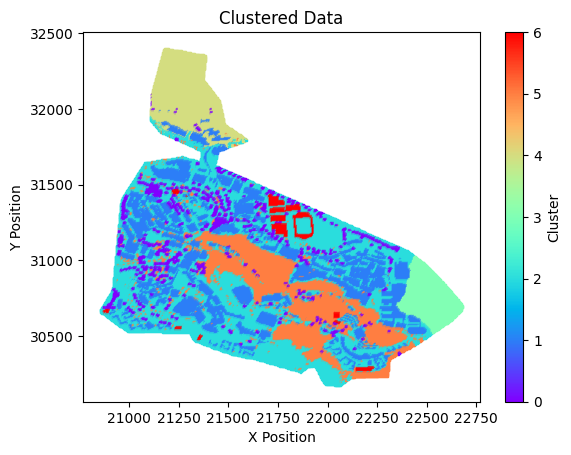

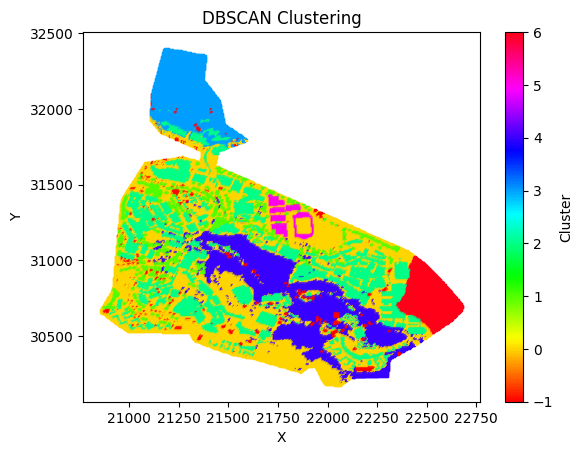

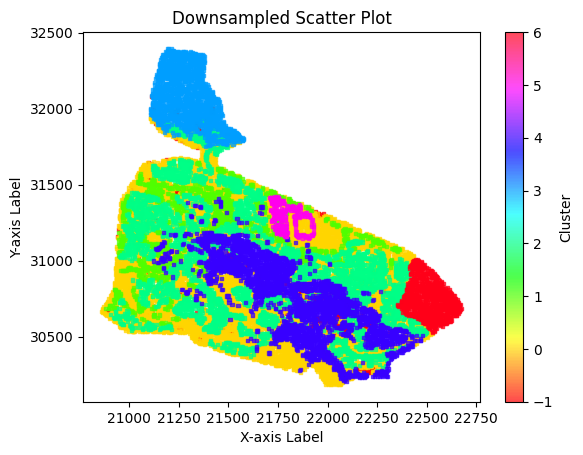

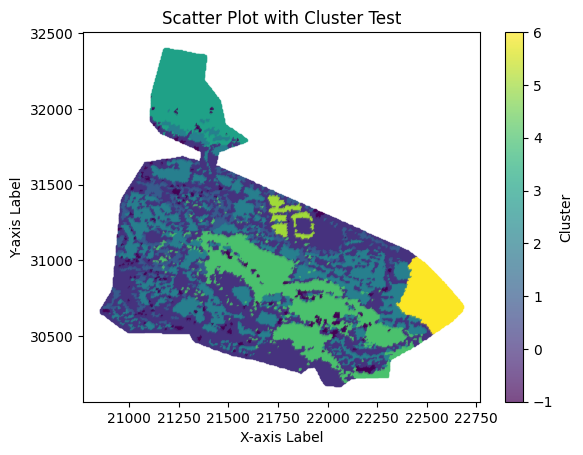

['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance', 'BLDandVEG_Sun_h', 'BLDandVEG_SkyExp', 'VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent', 'BLD_percent', 'BLD_Height', 'Terrain_height', 'VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance', 'cluster']


In [17]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = distance_features + veg_percentage  + bld_features + terrain_features + veg_distances


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 7
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()

#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.30
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Visualize Features

In [18]:
def plot_heatmaps(dataframe, feature_list, cmap_list, n_cols=3, filepath_dir: str = 'test', filename: str = 'example.png'):
    """
    Plot heatmaps for the specified features in the given DataFrame using the provided colormaps.

    Parameters:
    - dataframe: pd.DataFrame containing the data
    - feature_list: List of column names to plot as features
    - cmap_list: List of colormaps to use for each feature
    - n_cols: Number of columns in the subplot grid (default is 3)
    """
    # Ensure no duplicate entries by averaging duplicates
    dataframe = dataframe.groupby(['X', 'Y'], as_index=False).mean()

    # Define number of rows for the subplot grid
    n_rows = (len(feature_list) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)

    for i, (feature, cmap) in enumerate(zip(feature_list, cmap_list)):
        ax = axes[i // n_cols, i % n_cols]
        
        # Reshape data into a grid
        x_unique = np.sort(dataframe['X'].unique())
        y_unique = np.sort(dataframe['Y'].unique())
        X, Y = np.meshgrid(x_unique, y_unique)
        Z = dataframe.pivot(index='Y', columns='X', values=feature).values

        # Plot heatmap
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Heatmap of {feature}')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(False)

    # Remove any unused subplots
    if len(feature_list) < n_rows * n_cols:
        for j in range(len(feature_list), n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    filepath = os.path.join(filepath_dir, filename)
    if filepath != "":
        directory = os.path.dirname(filepath)
            
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")


    plt.savefig(filepath)

    plt.show()

In [ ]:
feature_df = griddf
display(feature_df.head(5))
#features = distance_features + sky_features   + veg_percentage  + bld_features + terrain_features + veg_distances
#feature_df.to_csv('test.csv')


terrain_features  = ['Terrain_height']
sky_features      = ['BLDandVEG_Sun_h', 'BLDandVEG_SkyExp']
bld_features      = ['BLD_percent', 'BLD_Height']
veg_percentage    = ['VEG_Tree_Height', 'VEG_TypeA_percent', 'VEG_TypeB_percent', 'VEG_TypeC_percent', 'VEG_TypeD_percent', 'VEG_TypeE_percent', 'VEG_Turf_percent', 'VEG_Shrub_percent']
veg_distances     = ['VEG_TypeA_distance', 'VEG_TypeB_distance', 'VEG_TypeC_distance', 'VEG_TypeD_distance', 'VEG_TypeE_distance', 'VEG_Turf_distance', 'VEG_Shrub_distance']
distance_features = ['STREET_CarPark_percent', 'STREET_CarPark_distance', 'STREET_CourtTrack_percent', 'STREET_CourtTrack_distance', 'STREET_Path_percent', 'STREET_Path_distance', 'STREET_Road_percent', 'STREET_Road_distance', 'STREET_Walkway_percent', 'STREET_Walkway_distance']


feature_list = veg_percentage
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3, filepath_dir, 'features_01')
feature_df.to_csv('test.csv')

feature_list = veg_distances
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_02')

feature_list = terrain_features + sky_features + bld_features
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_03')

feature_list = distance_features + ['cluster']
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_04')

# feature_list = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad']
# cmap_list = ['viridis', 'plasma', 'inferno', 'magma']
# plot_heatmaps(feature_df, feature_list, cmap_list)

### Regression Kriging

In [43]:
df_times = df.copy()
wsdf_cleaned = wsdf.copy()
df_times_cleaned = df_times.copy()

#### Filter the griddf

In [ ]:
#--------------------------------------------------------------------------
# MAIN
# FILTER AND SAVE THE GRIDDF for the main interpolation
#
#--------------------------------------------------------------------------

import pandas as pd
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree

# Define projection
wgs84 = Proj(init='epsg:4326')  # WGS84
utm = Proj(init='epsg:3414')    # Adjust to your UTM zone if needed

# Convert longitude and latitude to meters
def convert_location_data_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv')
participant_data_local_df = participant_data_local_df.dropna(subset=['c_longitude', 'c_latitude'])

# Convert participant data locations to meters
participant_data_local_df[['X', 'Y']] = participant_data_local_df.apply(
    lambda row: pd.Series(convert_location_data_to_meters(row['c_longitude'], row['c_latitude'])),
    axis=1
)

# Build a KDTree for participant_data_local_df
participant_tree = cKDTree(participant_data_local_df[['X', 'Y']])

# Define a function to check if there is a neighbor within a radius
def has_nearby_neighbors(x, y, radius=5):
    # Query the KDTree built from participant data
    distances, indices = participant_tree.query([x, y], k=len(participant_data_local_df), distance_upper_bound=radius)
    # Exclude the point itself and check if any other point is within the radius
    return any(dist < radius and dist > 0 for dist in distances)

# Create a 'keep' column for griddf
def check_keep(row):
    return has_nearby_neighbors(row['X'], row['Y'])

# Apply the neighbor check to griddf
griddf['keep'] = griddf.apply(check_keep, axis=1)

# Display the updated griddf
display(participant_data_local_df)
display(griddf)

griddf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep')

In [ ]:
#--------------------------------------------------------------------------
# SECONDARY
# FILTER AND SAVE THE GRIDDF for just the validation (esse00)
#
#--------------------------------------------------------------------------

import pandas as pd
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree

# Define projection
wgs84 = Proj(init='epsg:4326')  # WGS84
utm = Proj(init='epsg:3414')    # Adjust to your UTM zone if needed

# Convert longitude and latitude to meters
def convert_location_data_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

# Apply the function to create the new column


def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

man_participant_data_local_df = pd.read_csv(r"C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv")
man_participant_data_local_df['index_time'] = pd.to_datetime(man_participant_data_local_df['time_slice'],  format='%m/%d/%Y %H:%M:%S')

man_participant_data_local_df['c_latitude'] = man_participant_data_local_df.apply(combine_latitudes, axis=1)
man_participant_data_local_df['c_longitude'] = man_participant_data_local_df.apply(combine_longitudes, axis=1)
man_participant_data_local_df_filtered = man_participant_data_local_df.dropna(subset=['c_longitude', 'c_latitude'])

man_participant_data_local_df_filtered[['X', 'Y']] = man_participant_data_local_df_filtered.apply(
    lambda row: pd.Series(convert_location_data_to_meters(row['c_longitude'], row['c_latitude'])),
    axis=1
)

# Build a KDTree for participant_data_local_df
participant_tree = cKDTree(man_participant_data_local_df_filtered[['X', 'Y']])

# Define a function to check if there is a neighbor within a radius
def has_nearby_neighbors(x, y, radius=5):
    # Query the KDTree built from participant data
    distances, indices = participant_tree.query([x, y], k=len(man_participant_data_local_df_filtered), distance_upper_bound=radius)
    # Exclude the point itself and check if any other point is within the radius
    return any(dist < radius and dist > 0 for dist in distances)

# Create a 'keep' column for griddf
def check_keep(row):
    return has_nearby_neighbors(row['X'], row['Y'])

# Apply the neighbor check to griddf
griddf['keep'] = griddf.apply(check_keep, axis=1)

# Display the updated griddf
# display(man_participant_data_local_df_filtered)
display(griddf)

griddf.to_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep_validation.csv')

In [44]:
import plotly.express as px
import pandas as pd

# Load the data
griddf = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\krigging\griddf_withKeep.csv') #_validation

# Reset the index so it becomes a column
griddf.reset_index(inplace=True)

# Count of True and False values in 'keep' column
keep_counts = griddf['keep'].value_counts()
print("\nCount of True and False values in 'keep' column:")
print(keep_counts)

# Plotting with Plotly
fig = px.scatter(
    griddf,
    x='X',
    y='Y',
    color='keep',
    color_discrete_map={True: 'blue', False: 'red'},
    title='Grid Cells with Neighbors Within 5 Meters',
    labels={'X': 'X (meters)', 'Y': 'Y (meters)', 'keep': 'Has Neighbor Within 5 Meters'},
    height=800,
    width=800,
    hover_data={'index': True}  # Adding the index column to hover
)

fig.update_traces(marker=dict(size=1))

# Show the plot
fig.show()

# Filter the DataFrame for 'keep' == True
griddf = griddf.loc[griddf['keep'] == True]
grid = griddf



Count of True and False values in 'keep' column:
keep
True    18995
Name: count, dtype: int64


## Interpolation

In [ ]:
# cull features
print(features)
measure = 'AirTemperature'
#features = ['STREET_Walkway_distance', 'BLDandVEG_SkyExp', 'STREET_CourtTrack_distance', 'VEG_TypeA_distance']
#features = ['VEG_Shrub_distance', 'BLDandVEG_SkyExp', 'VEG_TypeE_distance', 'BLD_percent', 'BLDandVEG_Sun_h', 'VEG_TypeD_distance', 'VEG_TypeC_distance', 'STREET_Walkway_distance', 'STREET_Road_distance', 'STREET_Path_distance', 'Terrain_height', 'cluster', 'VEG_TypeA_distance', 'STREET_CourtTrack_distance', 'STREET_CarPark_distance', 'VEG_TypeB_distance', 'VEG_Tree_Height']

In [45]:
import os
import re
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pykrige.rk import RegressionKriging
import matplotlib.pyplot as plt
import warnings

print(measure)
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

# Constants
dirOut = r'D:\Simulation\InterpolationResults'
C = 0.001
gamma = 5
kernel = ['rbf']
n_estimators = 50
random_state = 4
n = 8
variogram_models = ['spherical']

debug = False
today = '2024-09-19_11-00'

if measure == "Radiation":
    minval = 0
    maxval = 1200
elif measure == "AirTemperature":
    minval = 22.5
    maxval = 40
else:
    minval = 0
    maxval = 50

# Ensure output directory exists
path = os.path.join(dirOut, today, measure)
os.makedirs(path, exist_ok=True)

# Initialize DataFrames
results_df = pd.DataFrame(columns=['time', 'X', 'Y', 'value'])
log_df = pd.DataFrame(columns=['hours', 'length_of_p', 'length_of_x', 'length_of_target', 'Success'])
feature_importance_df = pd.DataFrame()

def safe_float_conversion(x):
    try:
        return float(x)
    except ValueError:
        return x  

grid = griddf.copy()
grid = grid.applymap(safe_float_conversion)

def process_hours(df_ws, df_times_inter, grid, features, hours, model, n, variogram_model, index):
    """Process each hour and log the result."""
    if hours not in df_times_inter.columns:
        print(f"Column {hours} does not exist in the dataframe.")
        print("=" * 40)
        return False, None, None, None, None

    target = df_times_inter[hours].dropna()
    p = df_ws.loc[target.index, features]
    x = np.array(list(zip(df_ws.loc[target.index, 'X'], df_ws.loc[target.index, 'Y'])), dtype=float)
    target = np.array(target)

    if len(p) != len(target):
        print(f"Length mismatch after filtering: len(p) = {len(p)}, len(target) = {len(target)}.")
        print(f'Could not process {hours}, invalid length for p and target')
        return False, len(p), len(x), len(target), None

    print(f"Processing: Column {hours} exists in the dataframe. {index} out of {len(times)} processed.'")


    target_p = grid[features]
    target_x = np.array(list(zip(grid.X, grid.Y)))

    m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=variogram_model, verbose=False)
    
    if len(p) != len(x) or len(p) != len(target):
        print(f'Could not process {hours}, invalid length for p, x, and target')
        return False, len(p), len(x), len(target), None

    try:
        m_rk.fit(p, x, target)
    except ValueError as e:
        print(f"Skipping {hours} due to error: {e}")
        return False, len(p), len(x), len(target), None
    
    result = m_rk.predict(target_p, target_x)
    
    resultdf = grid.copy()
    resultdf[measure] = result
    
    # Append results to the results_df
    temp_df = resultdf[['id', 'X', 'Y']].copy()
    temp_df['time'] = hours
    temp_df['value'] = result
    global results_df
    results_df = pd.concat([results_df, temp_df])

    # Plot map if debug is enabled
    if debug:
        plot_map(resultdf, measure, hours)

    # Save result CSV
    filename = re.sub(r'[ :+]', '_', hours)
    filename = re.sub(r'-{2,}', '_', filename)
    resultdf.to_csv(f"{path}/{measure}_{filename}.csv", index=False)

    # Extract feature importances
    feature_importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else [None] * len(features)
    return True, len(p), len(x), len(target), feature_importances

def plot_map(resultdf, measure, hours):
    """Plot the results if debug mode is enabled."""
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
    plt.title('Scatter plot of ' + measure + ' (' + hours + ')')
    ax = plt.gca()
    ax.set_xlim(20800, 22500)
    ax.set_ylim(30200, 31700)
    plt.show()

print('----------- STARTING: 0 out of ' + str(len(times)))

index = 1
for k in variogram_models:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    for hours in times:
        # Load the appropriate weather data
        df_ws = wsdf_cleaned.copy()
        df_times_inter = df_times_cleaned.copy()
        df_ws = df_ws.applymap(safe_float_conversion)
        df_times_inter = df_times_inter.applymap(safe_float_conversion)

        success, len_p, len_x, len_target, feature_importances = process_hours(df_ws, df_times_inter, grid, features, hours, model, n, k, index)
        
        # Log the results
        log_entry = pd.DataFrame([{
            'hours': hours,
            'length_of_p': len_p,
            'length_of_x': len_x,
            'length_of_target': len_target,
            'Success': success
        }])

        log_df = pd.concat([log_df, log_entry], ignore_index=True)

        # Store feature importances in feature_importance_df
        if success:
            feature_importance_entry = pd.DataFrame([feature_importances], columns=features, index=[hours])
            global feature_importance_df
            feature_importance_df = pd.concat([feature_importance_df, feature_importance_entry])

        # print(f'{index} out of {len(times)} processed.')
        index += 1
        print("=" * 40)

# Save the log and feature importances to CSV
log_df.to_csv(f"{dirOut}/_{measure}_Log.csv", index=False)
feature_importance_df.to_csv(f"{dirOut}/_{measure}_FeatureImportances.csv")



WindSpeed
----------- STARTING: 0 out of 4828
Processing: Column Shortname exists in the dataframe. 1 out of 4828 processed.'
Skipping Shortname due to error: could not convert string to float: 'WS03'
Processing: Column 2024-03-01 16:22:00+08:00 exists in the dataframe. 2 out of 4828 processed.'
Finished learning regression model
Finished kriging residuals
Processing: Column 2024-01-27 18:38:00+08:00 exists in the dataframe. 3 out of 4828 processed.'
Finished learning regression model
Finished kriging residuals
Processing: Column 2024-02-21 13:32:00+08:00 exists in the dataframe. 4 out of 4828 processed.'
Finished learning regression model
Finished kriging residuals
Processing: Column 2024-02-21 16:40:00+08:00 exists in the dataframe. 5 out of 4828 processed.'
Finished learning regression model
Finished kriging residuals
Processing: Column 2024-03-01 16:56:00+08:00 exists in the dataframe. 6 out of 4828 processed.'
Finished learning regression model
Finished kriging residuals
Processin

### Feature Importance

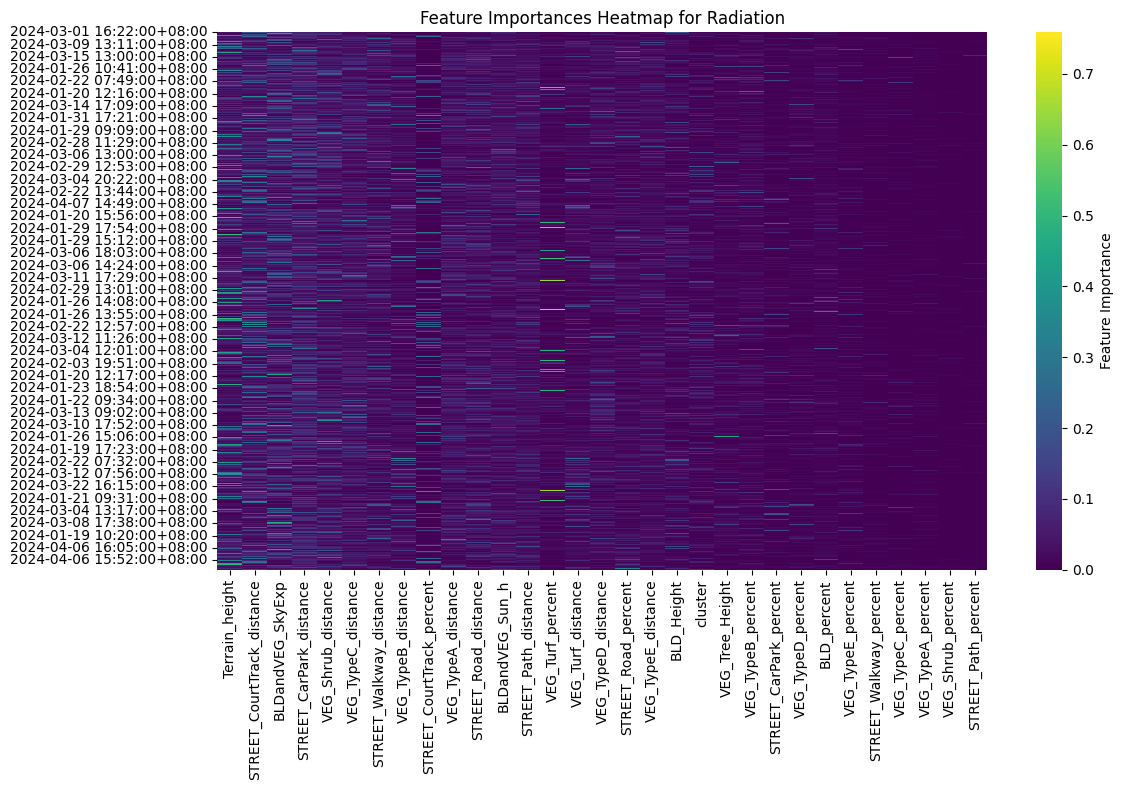

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
#measure = "AirTemperature"

# Load feature importances DataFrame (assumed to be saved as '_{measure}_FeatureImportances.csv')
feature_importance_df = pd.read_csv(f"{dirOut}/_{measure}_FeatureImportances.csv", index_col=0)

# Calculate mean importance for each feature across all timestamps
mean_importance = feature_importance_df.mean(axis=0)
sorted_features = mean_importance.sort_values(ascending=False).index

# Sort feature_importance_df by the mean importance
feature_importance_df = feature_importance_df[sorted_features]

# Add a row for the mean importances
mean_importance_df = pd.DataFrame(mean_importance[sorted_features]).T
mean_importance_df.index = ['Mean Importance']

# Combine the feature importances DataFrame with the mean importance DataFrame
combined_df = pd.concat([feature_importance_df, mean_importance_df], axis=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(combined_df, cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': 'Feature Importance'})
plt.title(f'Feature Importances Heatmap for {measure}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


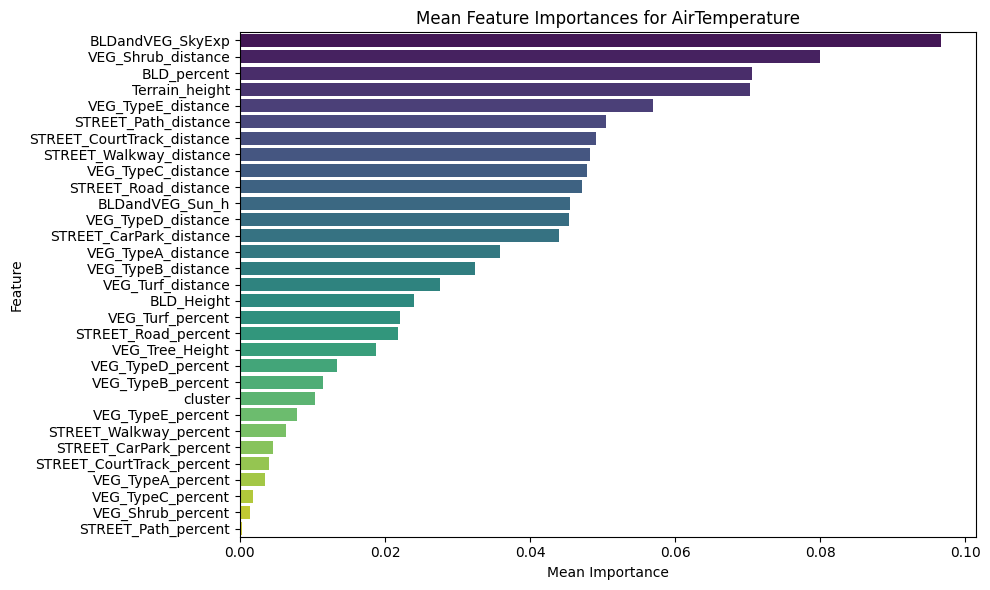

['BLDandVEG_SkyExp', 'VEG_Shrub_distance', 'BLD_percent', 'Terrain_height', 'VEG_TypeE_distance', 'STREET_Path_distance']


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load feature importances DataFrame
feature_importance_df = pd.read_csv(os.path.join('D:\Simulation\InterpolationResults', f"_{measure}_FeatureImportances.csv"), index_col=0)

# Calculate mean importance for each feature
mean_importance = feature_importance_df.mean(axis=0).sort_values(ascending=False)

# Create a DataFrame for the mean importances
mean_importance_df = pd.DataFrame(mean_importance).reset_index()
mean_importance_df.columns = ['Feature', 'Mean Importance']

# Plot the mean importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean Importance', y='Feature', data=mean_importance_df, palette='viridis')
plt.title(f'Mean Feature Importances for {measure}')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


filtered_importance_df = mean_importance_df[mean_importance_df['Mean Importance'] > 0.05]
# Print filtered features
print(filtered_importance_df['Feature'].tolist())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os

# Define the measures
measures = ["AirTemperature", "Humidity", "Radiation", "WindSpeed"]

# Initialize a dictionary to store daily data for each measure
daily_data_dict = {}

for measure in measures:
    file_path = f"{dirOut}/_{measure}_Log.csv"
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the log file into a DataFrame
        log_df = pd.read_csv(file_path)
        log_df = log_df.iloc[1:]
        # Ensure the 'hours' column is in datetime format
        log_df['hours'] = pd.to_datetime(log_df['hours'])
        
        # Set 'hours' as the index
        log_df.set_index('hours', inplace=True)
        
        # Store the data in the dictionary
        daily_data_dict[measure] = log_df
    else:
        print(f"File not found: {file_path}")

# Create a 2x2 subplot layout with increased height
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Increase height
axs = axs.flatten()  # Flatten the array of axes

# Define colors, markers, and edge color
colors = {'AirTemperature': '#680040', "Humidity": "#013078", 'Radiation': '#b52ce3', 'WindSpeed': '#424767'}
markers = {'AirTemperature': 'o', 'Humidity': 'o', 'Radiation': 'o', 'WindSpeed': 'o'}
edge_color = 'black'

# Define legend point size
legend_point_size = 25

# Plot each measure in its respective subplot
for i, measure in enumerate(measures):
    daily_data = daily_data_dict[measure]
    # Bin the data by hour and count number of entries in each bin
    binned_data = daily_data.resample('H').agg({'length_of_p': ['mean', 'count']})
    binned_data.columns = ['mean_length_of_p', 'count']
    
    # Scatter plot with size based on count
    sc = axs[i].scatter(binned_data.index, binned_data['mean_length_of_p'], 
                        color=colors[measure], 
                        marker=markers[measure], 
                        alpha=0.5,  # Transparency
                        s=binned_data['count'] * 7,  # Size proportional to count
                        edgecolor=edge_color)  # Black outline
    
    # Create evenly distributed x-ticks
    num_ticks = 15
    if len(binned_data.index) > num_ticks:
        tick_indices = np.linspace(0, len(binned_data.index) - 1, num_ticks).astype(int)
        ticks = binned_data.index[tick_indices].tolist()
    else:
        ticks = binned_data.index

    axs[i].set_xticks(ticks)
    axs[i].tick_params(axis='x', rotation=90)

    # Set x-axis date format to DD-MM
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Add grid
    axs[i].grid(True, linestyle='--', alpha=0.7)

    # Customize spines to remove top and right lines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Labels
    axs[i].set_xlabel('Date (DD-MM)')
    axs[i].set_ylabel('Count of Weatherstations')

    # Add text below the plot with letter prefix
    letter = chr(97 + i)  # 97 is ASCII for 'a'
    text = f'({letter}) Available Weatherstations used for {measure} Measure'
    axs[i].text(0.01, -0.205, text, ha='left', va='center', transform=axs[i].transAxes)


# # Add a single legend with fixed size markers to the last subplot
# for measure in measures:
#     axs[-1].scatter([], [], color=colors[measure], marker=markers[measure], 
#                     alpha=0.7, s=legend_point_size, edgecolor=edge_color, label=measure)

# axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.subplots_adjust(bottom=-0.130)  # Increase vertical space and bottom padding

plt.tight_layout()
plt.savefig(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\ModelUsedWeatherstations')

plt.show()

## Add Data to the Cozie Dataframe

In [ ]:
cozieDf = pd.read_csv(
    r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', 
    parse_dates=['index_time']
)

cozieDf['index_time'] = pd.to_datetime(cozieDf['index_time'], format='mixed')
cozieDf['index_time'] = cozieDf['index_time'].dt.tz_convert('Asia/Singapore')


In [79]:
cozieDf = pd.read_csv(r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Thermal_Walk\Process\Dataset.csv', parse_dates=['time_slice'])

cozieDf['index_time'] = pd.to_datetime(cozieDf['time_slice'], format='mixed') 
cozieDf['index_time'] = cozieDf['index_time'].dt.tz_localize('Asia/Singapore')

def combine_longitudes(row):
    if not pd.isnull(row['Scoria_longitude']):
        return row['Scoria_longitude']
    elif not pd.isnull(row['ws_longitude']):
        return row['ws_longitude']
    elif not pd.isnull(row['ts_longitude']):
        return row['ts_longitude']
    else:
        return None

def combine_latitudes(row):
    if not pd.isnull(row['Scoria_latitude']):
        return row['Scoria_latitude']
    elif not pd.isnull(row['ws_latitude']):
        return row['ws_latitude']
    elif not pd.isnull(row['ts_latitude']):
        return row['ts_latitude']
    else:
        return None

cozieDf['c_longitude'] = cozieDf.apply(combine_longitudes, axis=1)
cozieDf['c_latitude'] = cozieDf.apply(combine_latitudes, axis=1)

In [ ]:
import os
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from datetime import timedelta
import pytz
import warnings

# normalize?


# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")

fileDirectory = r'D:\Simulation\InterpolationResults\2024-09-03_10-35'

# List of measures to process
measures = ['AirTemperature', 'Radiation', 'Humidity', 'WindSpeed']

wgs84 = Proj(init='epsg:4326')
utm = Proj(init='epsg:3414')


# Round index_time to nearest second
cozieDf['index_time'] = cozieDf['index_time'].dt.round('S')

# Copy Cozie DataFrame and prepare columns for each measure
cozieMeasureDf = cozieDf.copy()
for measure in measures:
    cozieMeasureDf[measure] = np.nan  
    cozieMeasureDf[measure + '_time_difference'] = np.nan  # Column to store time difference

def ConvertLocationDataToMeters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

def findCozieLocation():
    """
    Find valid longitude and latitude entries in Cozie DataFrame,
    convert them to meters, and return the index and transformed coordinates.
    """
    valid_entries = cozieDf.dropna(subset=['c_longitude', 'c_latitude'])
    
    for idx, row in valid_entries.iterrows():
        lon, lat = row['c_longitude'], row['c_latitude']
        x, y = ConvertLocationDataToMeters(lon, lat)
        
        yield idx, row['index_time'], x, y

def parse_filename_timestamp(filename, measure):
    """
    Parse the timestamp from the filename considering timezone offset and make it timezone-aware.
    """
    # Remove the measure prefix and file extension
    timestamp_part = filename[len(measure) + 1:-4]  # Remove measure name and '.csv', and adjust for underscore

    # Extract parts: 'YYYY-MM-DD_HH_MM_SS_TZ'
    parts = timestamp_part.split('_')
    
    # Construct timestamp string and timezone offset
    timestamp_str = '_'.join(parts[:4])  # 'YYYY-MM-DD_HH_MM_SS'
    tz_offset_str = '_'.join(parts[4:])  # '08_00'
    
    # Parse the timestamp
    try:
        file_time = pd.to_datetime(timestamp_str, format='%Y-%m-%d_%H_%M_%S')
        tz_offset_hours = int(tz_offset_str.split('_')[0])
        tz_offset_minutes = int(tz_offset_str.split('_')[1])
        tz_offset = pytz.FixedOffset(tz_offset_hours * 60 + tz_offset_minutes)
        file_time = tz_offset.localize(file_time)

        # Convert to Singapore time
        file_time = file_time.astimezone(pytz.timezone('Asia/Singapore'))

        return file_time
    except ValueError as e:
        print(f"Error parsing timestamp from filename {filename}: {e}")
        return None

def findClosestMeasureFile(index_time, measure):
    """
    Find the closest measure file based on the measure type and index_time.
    """
    min_time_diff = pd.Timedelta.max
    closest_file = None

    # Ensure index_time is timezone-aware
    if isinstance(index_time, pd.Timestamp):
        if index_time.tzinfo is None:
            index_time = index_time.tz_localize('Asia/Singapore')
    else:
        index_time = pd.Timestamp(index_time).tz_localize('Asia/Singapore')

    measure_folder = os.path.join(fileDirectory, measure)
    for root, dirs, files in os.walk(measure_folder):
        for file in files:
            if measure in file:
                file_time = parse_filename_timestamp(file, measure)
                if file_time is not None:
                    # Calculate time difference
                    time_diff = abs(file_time - index_time)
                    
                    if time_diff < min_time_diff:
                        min_time_diff = time_diff
                        closest_file = os.path.join(root, file)

    return closest_file, min_time_diff

def findGridLocation(measureFilePath, x, y, measure):
    """
    Find the closest grid cell in the measure file corresponding to the given coordinates (x, y).
    Update the CozieMeasureDf with the found value.
    """
    measureDf = pd.read_csv(measureFilePath)
    
    # Ensure the columns match the measureDf file
    if 'X' not in measureDf.columns or 'Y' not in measureDf.columns:
        raise ValueError(f"Required columns 'X' or 'Y' are missing in file {measureFilePath}")
    
    # Compute the distance
    measureDf['distance'] = np.sqrt((measureDf['X'] - x)**2 + (measureDf['Y'] - y)**2)
    
    # Find the closest row
    closest_row = measureDf.loc[measureDf['distance'].idxmin()]
    return closest_row[measure]

# Process the first 100 locations in Cozie DataFrame and update measurements for all measures
count = 0
for idx, index_time, x, y in findCozieLocation():
    # if count >= 10:
    #     break  # Stop after processing 100 locations

    for measure in measures:
        measureFilePath, time_difference = findClosestMeasureFile(index_time, measure)
        
        if measureFilePath:
            measurement_value = findGridLocation(measureFilePath, x, y, measure)
            cozieMeasureDf.loc[idx, measure] = measurement_value
            cozieMeasureDf.loc[idx, measure + '_time_difference'] = time_difference.total_seconds()
        else:
            print(f"Warning: No {measure} file found for index_time {index_time}. Data remains NaN for this entry.")
    
    count += 1  # Increment the counter
    print(f"Processed location {count}")

print("Processing complete.")


In [ ]:
import os
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from datetime import timedelta
import pytz
import warnings
from concurrent.futures import ThreadPoolExecutor

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pyproj")



fileDirectory = r'D:\Simulation\InterpolationResults\2024-09-12_20-00'



measures = ['AirTemperature', 'Radiation', 'Humidity', 'WindSpeed']

wgs84 = Proj(init='epsg:4326')
utm = Proj(init='epsg:3414')

cozieDf['index_time'] = cozieDf['index_time'].dt.round('S')
cozieMeasureDf = cozieDf.copy()
for measure in measures:
    cozieMeasureDf[measure] = np.nan  
    cozieMeasureDf[measure + '_time_difference'] = np.nan  

def ConvertLocationDataToMeters(lon, lat):
    return transform(wgs84, utm, lon, lat)

def findCozieLocation():
    valid_entries = cozieDf.dropna(subset=['c_longitude', 'c_latitude'])
    for idx, row in valid_entries.iterrows():
        lon, lat = row['c_longitude'], row['c_latitude']
        x, y = ConvertLocationDataToMeters(lon, lat)
        yield idx, row['index_time'], x, y

def parse_filename_timestamp(filename, measure):
    timestamp_part = filename[len(measure) + 1:-4]  
    parts = timestamp_part.split('_')
    timestamp_str = '_'.join(parts[:4])  
    tz_offset_str = '_'.join(parts[4:])  
    try:
        file_time = pd.to_datetime(timestamp_str, format='%Y-%m-%d_%H_%M_%S')
        tz_offset_hours = int(tz_offset_str.split('_')[0])
        tz_offset_minutes = int(tz_offset_str.split('_')[1])
        tz_offset = pytz.FixedOffset(tz_offset_hours * 60 + tz_offset_minutes)
        file_time = tz_offset.localize(file_time)
        file_time = file_time.astimezone(pytz.timezone('Asia/Singapore'))
        return file_time
    except ValueError as e:
        print(f"Error parsing timestamp from filename {filename}: {e}")
        return None

def build_file_index():
    file_index = {}
    for measure in measures:
        measure_folder = os.path.join(fileDirectory, measure)
        files = os.listdir(measure_folder)
        timestamps = {parse_filename_timestamp(file, measure): os.path.join(measure_folder, file)
                        for file in files}
        file_index[measure] = timestamps
    return file_index

def findClosestMeasureFile(index_time, measure, file_index):
    min_time_diff = pd.Timedelta.max
    closest_file = None

    if isinstance(index_time, pd.Timestamp) and index_time.tzinfo is None:
        index_time = index_time.tz_localize('Asia/Singapore')

    for file_time, path in file_index[measure].items():
        if file_time is not None:
            time_diff = abs(file_time - index_time)
            if time_diff < min_time_diff:
                min_time_diff = time_diff
                closest_file = path

    return closest_file, min_time_diff

def findGridLocation(measureFilePath, x, y, measure):
    measureDf = pd.read_csv(measureFilePath)
    if 'X' not in measureDf.columns or 'Y' not in measureDf.columns:
        raise ValueError(f"Required columns 'X' or 'Y' are missing in file {measureFilePath}")
    
    measureDf['distance'] = np.sqrt((measureDf['X'] - x)**2 + (measureDf['Y'] - y)**2)
    closest_row = measureDf.loc[measureDf['distance'].idxmin()]
    return closest_row[measure]

def process_location(location_data, file_index):
    idx, index_time, x, y = location_data
    for measure in measures:
        measureFilePath, time_difference = findClosestMeasureFile(index_time, measure, file_index)
        if measureFilePath:
            measurement_value = findGridLocation(measureFilePath, x, y, measure)
            cozieMeasureDf.loc[idx, measure] = measurement_value
            cozieMeasureDf.loc[idx, measure + '_time_difference'] = time_difference.total_seconds()
            print(f"processed location for {index_time}")
        else:
            print(f"Warning: No {measure} file found for index_time {index_time}. Data remains NaN for this entry.")

file_index = build_file_index()

with ThreadPoolExecutor() as executor:
    list(executor.map(lambda location: process_location(location, file_index), findCozieLocation()))

print("Processing complete.")


In [81]:
cozieMeasureDf.to_csv('cozieMeasureDf.csv')
